In [12]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as tt

In [13]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [3]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# labels
label_list = []
for i in range(10):
    label_list.append(str(i))
for i in range(65, 91):
    label_list.append(str(chr(i)))
for i in range(97, 123):
    label_list.append(str(chr(i)))


size of dataset 697932
20
torch.Size([50, 1, 64, 64])
3


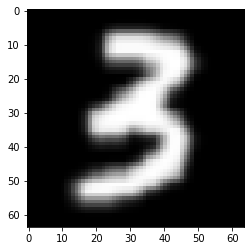

In [5]:
import torchvision
from torch.utils.data import DataLoader

dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='byclass',
    transform=tt.Compose([
                    lambda img: tt.functional.rotate(img, -90),
                    lambda img: tt.functional.hflip(img),
                    tt.ToTensor(),
                    tt.Resize(64)
                ]),
    download=True
    )
print("size of dataset", len(dataset))
train_dataset, _ = torch.utils.data.random_split(dataset, [1000, 696932])

train_dataloader = DataLoader(train_dataset,
                         batch_size=50,
                         shuffle=True)
print(len(train_dataloader))
# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges, label = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])
print(label_list[int(label[0])])
plt.imshow(imges[0][0], cmap='gray')


In [6]:
# ラベル学習のための関数
# One-hotエンコーディング
def onehot_encode(label, device, num_class=62):
    eye = torch.eye(num_class, device=device)
    # サイズ(batch_size, num_class, 1, 1)のテンソル
    return eye[label].view(-1, num_class, 1, 1)

# 画像とラベルの連結
def concat_image_label(image, label, device, num_class=62):
    # 画像tensor sizeを取得
    batch_size, _, height, width = image.shape

    # ラベルをOne-hotベクトル化
    one_hot_label = onehot_encode(label, device)

    # 画像のサイズに合わせるようにラベルを拡張
    one_hot_label = one_hot_label.expand(batch_size, num_class, height, width)

    # 画像とラベルをチェンネル方向(dim=1)で連結
    return torch.cat((image, one_hot_label), dim=1)

# ノイズとラベルの連結
def concat_noise_label(noise, label, device):
    one_hot_label =onehot_encode(label, device)
    return torch.cat((noise, one_hot_label), dim=1)

In [7]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [8]:
class Discriminator(nn.Module):
    
    def __init__(self, nch=1, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(nch, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャンネルは１つだけ
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
            
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out.squeeze()

In [9]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# パラメータをハードコーディング
z_dim = 100
mini_batch_size = 50


# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# ネットワークをGPUへ
net_G = Generator(z_dim=z_dim+62).to(device)
net_D = Discriminator(nch=1+62).to(device)

# 初期化の実施
net_G.apply(weights_init)
net_D.apply(weights_init)
print("ネットワークの初期化の完了")

使用デバイス： cpu
ネットワークの初期化の完了


In [10]:
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
writer = SummaryWriter()

# モデルを学習させる関数を作成
def train_model(net_G, net_D, dataloader, num_epochs, mini_batch_size, z_dim, device, outf):

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(net_G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(net_D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')


    net_G.train()  # モデルを訓練モードに
    net_D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for batch, data in enumerate(dataloader):
            imges = data[0]
            label = data[1]
            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)
            label = label.to(device)
            real_image_label = concat_image_label(imges, label, device)

            net_D.zero_grad()
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            noise = torch.randn(mini_batch_size, z_dim, 1 ,1, device=device)
            fake_label = torch.randint(62, (mini_batch_size,), dtype=torch.long, device=device)
            fake_noise_label = concat_noise_label(noise, fake_label, device) #ノイズとラベルを連結

            #識別の目標値を設定
            real_target = torch.full((mini_batch_size,), 1., device=device) #本物は1
            fake_target = torch.full((mini_batch_size,), 0., device=device) #偽物は0


            # 本物画像に対する損失値
            d_out_real = net_D(real_image_label)
            d_loss_real = criterion(d_out_real, real_target.float())

            # 偽物画像を生成し、偽物画像に対する損失値
            fake_image = net_G(fake_noise_label)
            # 偽物画像とラベルを結合
            fake_image_label = concat_image_label(fake_image, fake_label, device)
            d_out_fake = net_D(fake_image_label.detach())
            d_loss_fake = criterion(d_out_fake, fake_target.float())

            # net_Dの損失値の合計
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            net_G.zero_grad()

            d_out_fake = net_D(fake_image_label)
            # 誤差を計算
            g_loss = criterion(d_out_fake, label.float())

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
        # 学習率の推移の保存
        writer.add_scalar('Epoch_D_Loss', epoch_d_loss/batch_size, epoch)
        writer.add_scalar('Epoch_G_Loss', epoch_g_loss/batch_size, epoch)

        if (epoch+1) % 5 == 0:
            for i in range(62):
                sample_noise = torch.randn(62, z_dim, 1 ,1, device=device)
                sample_label = [i for i in range(62)] #0~9の値の繰り返す（5回）
                sample_label = torch.tensor(sample_label, dtype=torch.long, device=device) #torch.longはint64を指す
                fake_noise_label = concat_noise_label(sample_noise, sample_label, device) #ノイズとラベルを連結
                fake_image = net_G(fake_noise_label)
                vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1, i), normalize=True, nrow=10)


        # モデルの保存
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            torch.save(net_D, outf + "net_D.pth")
            torch.save(net_G, outf + "net_G.pth")

        t_epoch_start = time.time()
        

    return net_G, net_D


In [11]:
# 学習・検証の実施
num_epochs = 200
outf = './result_emnist'
G_update, D_update = train_model(net_G, net_D, dataloader=train_dataloader, num_epochs=num_epochs, mini_batch_size=mini_batch_size, z_dim=z_dim, device=device, outf=outf)

-------------
Epoch 0/200
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.4763 ||Epoch_G_Loss:4.8792
timer:  56.9318 sec.
-------------
Epoch 1/200
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.4165 ||Epoch_G_Loss:8.2477
timer:  54.4274 sec.
-------------
Epoch 2/200
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.3341 ||Epoch_G_Loss:12.4119
timer:  59.2121 sec.
-------------
Epoch 3/200
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.3949 ||Epoch_G_Loss:12.0019
timer:  54.9664 sec.
-------------
Epoch 4/200
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.3571 ||Epoch_G_Loss:12.5096
timer:  53.8833 sec.
-------------
Epoch 5/200
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.3360 ||Epoch_G_Loss:14.4542
timer:  56.8513 sec.
-------------
Epoch 6/200
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.2950 ||Epoch_G_Loss:18.7130
timer:  56.2835 sec.
-------------
Epoch 7/200
-------------
（tr

In [15]:
fake_label_list = []
s = "HappyNewYear"
for i in range(len(s)):
    fake_label_list.append(label_list.index(s[i]))
print(fake_label_list)

[17, 36, 51, 51, 60, 23, 40, 58, 34, 40, 36, 53]


In [25]:
import torchvision.utils as vutils
z_dim = 100
sample_noise = torch.randn(len(fake_label_list), z_dim, 1 ,1, device=device)
sample_label = torch.tensor(fake_label_list, dtype=torch.long, device=device) #torch.longはint64を指す
fake_noise_label = concat_noise_label(sample_noise, sample_label, device) #ノイズとラベルを連結
fake_image = net_G(fake_noise_label)
vutils.save_image(fake_image, './fake_sample.png'.format(normalize=True))
